## 1. Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
from tqdm import tqdm
import pandas as pd
import json
import shutil
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for inline display in notebook
%matplotlib inline

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

print('✓ Libraries imported successfully')

✓ Libraries imported successfully


## 2. Configuration

In [ ]:
# Base directories
BASE_DIR = Path.cwd().parent
MODEL_NAME = "yolo11n"  # Model name without .pt extension

# Choose YOLO model versions that are fully supported with ultralytics:
# ✅ YOLOv8: 'yolov8n', 'yolov8s', 'yolov8m', 'yolov8l', 'yolov8x'
# ✅ YOLOv9: 'yolov9s', 'yolov9m', 'yolov9l', 'yolov9x'
# ✅ YOLOv10: 'yolov10n', 'yolov10s', 'yolov10m', 'yolov10l', 'yolov10x'
# ✅ YOLO11: 'yolo11n', 'yolo11s', 'yolo11m', 'yolo11l', 'yolo11x'
# ✅ YOLO12: 'yolo12n', 'yolo12s', 'yolo12m', 'yolo12l', 'yolo12x'

MODELS_DIR = BASE_DIR / 'models' / MODEL_NAME
TMP_DIR = BASE_DIR / 'tmp' / MODEL_NAME
TRAINING_DIR = BASE_DIR / 'training'
RUNS_DIR = TRAINING_DIR / 'runs'

# Dataset Selection - Choose one:
# Option 1: Full dataset (~100k images) - use for final training
YOLO_DATASET_ROOT = BASE_DIR / 'bdd100k_yolo'
DATA_YAML_PATH = YOLO_DATASET_ROOT / 'data.yaml'

# Option 2: Limited dataset (representative samples - for quick testing)
# YOLO_DATASET_ROOT = BASE_DIR / 'bdd100k_yolo_limited'
# DATA_YAML_PATH = YOLO_DATASET_ROOT / 'data.yaml'

# Verify dataset exists
if not DATA_YAML_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found: {DATA_YAML_PATH}\n\n"
        f"Please run the dataset preparation script first:\n"
        f"  python3 process_bdd100k_to_yolo_dataset.py\n"
    )

# Generate timestamp and run name
RUN_TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
RUN_NAME = f'{MODEL_NAME}_training_{RUN_TIMESTAMP}'
W_B_PROJECT = "yolo-bdd100k-training"

# Create run-specific directory
RUN_DIR = RUNS_DIR / RUN_NAME
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Create other directories
TMP_DIR.mkdir(parents=True, exist_ok=True)
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# Read dataset configuration from data.yaml
import yaml
with open(DATA_YAML_PATH, 'r') as f:
    data_config = yaml.safe_load(f)
    NUM_CLASSES = data_config['nc']
    CLASS_NAMES = {i: name for i, name in enumerate(data_config['names'])}

print('✓ Configuration loaded')
print(f'  Model: {MODEL_NAME}')
print(f'  Dataset: {YOLO_DATASET_ROOT.name}')
print(f'  Data YAML: {DATA_YAML_PATH}')
print(f'  Run directory: {RUN_DIR}')
print(f'  Classes: {NUM_CLASSES}')

✓ Configuration loaded
  Model: yolo11n
  Model directory: /Users/mahdy/projects/computer_vision_yolo/models/yolo11n
  Train images: /Users/mahdy/projects/computer_vision_yolo/bdd100k_tmp_images_limited/train
  Train labels: /Users/mahdy/projects/computer_vision_yolo/bdd100k_tmp_labels_limited/train
  Val images: /Users/mahdy/projects/computer_vision_yolo/bdd100k_tmp_images_limited/val
  Val labels: /Users/mahdy/projects/computer_vision_yolo/bdd100k_tmp_labels_limited/val
  Run directory: /Users/mahdy/projects/computer_vision_yolo/training/runs/yolo11n_training_20251121_041144
  Classes: 10
  Dataset: bdd100k_tmp_images_limited


## 3. Load Base YOLO Model

In [3]:
# Load YOLO model with automatic download
model_path = MODELS_DIR / f'{MODEL_NAME}.pt'

if not model_path.exists():
    print(f'Model not found at {model_path}')
    print(f'Downloading {MODEL_NAME} ...')
    
    try:
        # Download model
        MODEL_NAME_n = MODEL_NAME
        if MODEL_NAME.startswith('yolo11') or MODEL_NAME.startswith('yolo12'):
            MODEL_NAME_n = MODEL_NAME + '.pt'
        model = YOLO(MODEL_NAME_n)
        
        # Create models directory
        MODELS_DIR.mkdir(parents=True, exist_ok=True)
        
        # Move from cache
        try:
            import glob
            cache_patterns = [
                str(Path.home() / '.cache' / 'ultralytics' / '**' / f'{MODEL_NAME}.pt'),
                str(Path.home() / '.config' / 'Ultralytics' / '**' / f'{MODEL_NAME}.pt'),
            ]
            
            model_found = False
            for pattern in cache_patterns:
                cache_paths = glob.glob(pattern, recursive=True)
                if cache_paths:
                    shutil.move(cache_paths[0], model_path)
                    print(f'✓ Model downloaded and saved to {model_path}')
                    print(f'  Size: {model_path.stat().st_size / (1024*1024):.1f} MB')
                    
                    # Clean up cache directory
                    cache_dir = Path(cache_paths[0]).parent
                    if cache_dir.exists() and not any(cache_dir.iterdir()):
                        cache_dir.rmdir()
                        print(f'  ✓ Cleaned up cache directory')
                    
                    model_found = True
                    break
            
            if not model_found:
                print(f'✓ Model loaded from ultralytics cache')
        except Exception as save_error:
            print(f'⚠️  Could not move model: {save_error}')
            print(f'✓ Model loaded successfully from cache')
            
    except Exception as e:
        print(f'\n❌ Error downloading model: {e}')
        raise
else:
    model = YOLO(str(model_path))
    print(f'✓ Model loaded from {model_path}')

print(f'\n📊 Base Model: {MODEL_NAME}')
print(f'  Classes in model: {len(model.names)}')
print(f'  Task: {model.task}')

✓ Model loaded from /Users/mahdy/projects/computer_vision_yolo/models/yolo11n/yolo11n.pt

📊 Base Model: yolo11n
  Classes in model: 80
  Task: detect


## 4. Load Optimized Hyperparameters

In [4]:
# Load hyperparameters from tuning phase
hyperparams_path = TRAINING_DIR / f'{MODEL_NAME}_best_hyperparameters.json'

if hyperparams_path.exists():
    with open(hyperparams_path, 'r') as f:
        tuning_results = json.load(f)
    
    hyperparams = tuning_results['hyperparameters']
    
    print('✓ Optimized hyperparameters loaded from tuning phase')
    print(f'  Source: {hyperparams_path}')
    print(f'  Best trial: {tuning_results["optimization_results"]["best_trial"]}')
    print(f'  Best mAP@0.5: {tuning_results["optimization_results"]["best_map50"]:.4f}')
    print(f'  Total trials: {tuning_results["optimization_results"]["total_trials"]}')
    print(f'\n📋 Training Configuration:')
    print(f'  Epochs: {hyperparams["epochs"]}')
    print(f'  Batch size: {hyperparams["batch"]}')
    print(f'  Image size: {hyperparams["imgsz"]}')
    print(f'  Patience: {hyperparams["patience"]}')
else:
    print(f'⚠️  No hyperparameters found at {hyperparams_path}')
    print('Using default hyperparameters...')
    
    hyperparams = {
        'epochs': 100,
        'batch': 16,
        'imgsz': 640,
        'patience': 20,
        'save': True,
        'plots': True,
        'verbose': True,
        'exist_ok': True
    }
    
    print('✓ Using default hyperparameters')

✓ Optimized hyperparameters loaded from tuning phase
  Source: /Users/mahdy/projects/computer_vision_yolo/training/yolo11n_best_hyperparameters.json
  Best trial: 0
  Best mAP@0.5: 0.0000
  Total trials: 20

📋 Training Configuration:
  Epochs: 100
  Batch size: 16
  Image size: 640
  Patience: 20


## 5. Verify Dataset Structure

In [ ]:
# Verify dataset structure is ready
print('Verifying YOLO dataset structure...')
print(f'\n📁 Dataset Root: {YOLO_DATASET_ROOT}')

# Check splits
for split in ['train', 'val', 'test']:
    images_dir = YOLO_DATASET_ROOT / 'images' / split
    labels_dir = YOLO_DATASET_ROOT / 'labels' / split
    
    if images_dir.exists() and labels_dir.exists():
        num_images = len(list(images_dir.glob('*.jpg'))) + len(list(images_dir.glob('*.png')))
        num_labels = len(list(labels_dir.glob('*.txt')))
        print(f'  ✓ {split:5s}: {num_images:6d} images, {num_labels:6d} labels')
    else:
        print(f'  ⚠️  {split:5s}: Directory not found')

# Verify data.yaml
print(f'\n📄 Configuration: {DATA_YAML_PATH}')
print(f'  Classes: {NUM_CLASSES}')
print(f'  Names: {CLASS_NAMES}')

print('\n✓ Dataset structure verified and ready for training')

Setting up dataset structure...
✓ Dataset structure prepared
  Training images: 250
  Training labels: 250
  Validation images: 100
  Validation labels: 100
  Data YAML: /Users/mahdy/projects/computer_vision_yolo/tmp/yolo11n/yolo_training_dataset/data.yaml


## 6. Train Model

In [ ]:
# Train the model with optimized hyperparameters
print('=' * 80)
print('STARTING TRAINING')
print('=' * 80)
print(f'Model: {MODEL_NAME}')
print(f'Dataset: {USED_DATASET}')
print(f'Epochs: {hyperparams["epochs"]}')
print(f'Batch size: {hyperparams["batch"]}')
print('=' * 80)

# Train model using data.yaml directly
results = model.train(
    data=str(DATA_YAML_PATH),
    epochs=hyperparams['epochs'],
    batch=hyperparams['batch'],
    imgsz=hyperparams['imgsz'],
    **{k: v for k, v in hyperparams.items() if k not in ['epochs', 'batch', 'imgsz', 'project', 'name']},
    project=str(RUN_DIR),
    name='train',
    exist_ok=True
)

print('\n' + '=' * 80)
print('TRAINING COMPLETED')
print('=' * 80)
print(f'Training results saved to: {RUN_DIR}/train')
print('=' * 80)

STARTING TRAINING
Model: yolo11n
Dataset: bdd100k_tmp_images_limited
Epochs: 100
Batch size: 16
Ultralytics 8.3.229 🚀 Python-3.12.3 torch-2.9.1 CPU (Apple M3)
Ultralytics 8.3.229 🚀 Python-3.12.3 torch-2.9.1 CPU (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=5.917022549267169, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5129695700716764, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/mahdy/projects/computer_vision_yolo/tmp/yolo11n/yolo_training_dataset/data.yaml, degrees=38.97792655987208, deterministic=True, device=cpu, dfl=1.524756431632238, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.41622132040021087, flipud=0.48495492608099716, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015601864044243652, hsv_s=0.1403950683025824, hsv_v=0.05227525095137952, imgsz=640, int8=Fal

KeyboardInterrupt: 

## 7. Validate Trained Model

In [8]:
print('=' * 80)
print('VALIDATING TRAINED MODEL')
print('=' * 80)

# Load the best trained model
best_model_path = RUN_DIR / 'train' / 'weights' / 'best.pt'
trained_model = YOLO(str(best_model_path))

# Validate on validation set
val_results = trained_model.val(
    data=str(data_yaml_path),
    split='val'
)

# Extract metrics
metrics = {
    'mAP@0.5': float(val_results.box.map50),
    'mAP@0.5:0.95': float(val_results.box.map),
    'precision': float(val_results.box.mp),
    'recall': float(val_results.box.mr),
    'fitness': float(val_results.fitness)
}

# Per-class metrics
class_metrics = {}
for i, class_name in CLASS_NAMES.items():
    if i < len(val_results.box.ap50):
        class_metrics[class_name] = {
            'AP@0.5': float(val_results.box.ap50[i]),
            'AP@0.5:0.95': float(val_results.box.ap[i])
        }

print('\n' + '=' * 80)
print('VALIDATION RESULTS')
print('=' * 80)
print(f'mAP@0.5: {metrics["mAP@0.5"]:.4f}')
print(f'mAP@0.5:0.95: {metrics["mAP@0.5:0.95"]:.4f}')
print(f'Precision: {metrics["precision"]:.4f}')
print(f'Recall: {metrics["recall"]:.4f}')
print(f'Fitness: {metrics["fitness"]:.4f}')
print('=' * 80)

VALIDATING TRAINED MODEL
Ultralytics 8.3.229 🚀 Python-3.12.3 torch-2.9.1 CPU (Apple M3)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1851.4±1026.2 MB/s, size: 63.9 KB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1851.4±1026.2 MB/s, size: 63.9 KB)
val: Scanning /Users/mahdy/projects/computer_vision_yolo/tmp/yolo11n/yolo_training_dataset/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 320.4Kit/s 0.0s
val: Scanning /Users/mahdy/projects/computer_vision_yolo/tmp/yolo11n/yolo_training_dataset/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 320.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.1s/it 8.0s1.5ss
                 Class     Images  Instances      Box(P         

## 8. Save Fine-tuned Model

In [9]:
print('=' * 80)
print('SAVING FINE-TUNED MODEL')
print('=' * 80)

# Create fine-tuned model filename with timestamp
finetuned_date = datetime.now().strftime('%Y%m%d')
finetuned_model_name = f'{MODEL_NAME}_finetuned-{finetuned_date}.pt'
finetuned_model_path = MODELS_DIR / finetuned_model_name

# Copy best model to models directory
shutil.copy2(best_model_path, finetuned_model_path)

print(f'✓ Fine-tuned model saved to: {finetuned_model_path}')
print(f'  Size: {finetuned_model_path.stat().st_size / (1024*1024):.1f} MB')

# Save training metadata
metadata = {
    'model_name': MODEL_NAME,
    'finetuned_model': finetuned_model_name,
    'base_model': f'{MODEL_NAME}.pt',
    'training_date': datetime.now().isoformat(),
    'dataset': USED_DATASET,
    'hyperparameters': hyperparams,
    'validation_metrics': metrics,
    'class_metrics': class_metrics,
    'training_results_dir': str(RUN_DIR / 'train')
}

metadata_path = MODELS_DIR / f'{MODEL_NAME}_finetuned-{finetuned_date}_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f'✓ Metadata saved to: {metadata_path}')
print('=' * 80)

SAVING FINE-TUNED MODEL
✓ Fine-tuned model saved to: /Users/mahdy/projects/computer_vision_yolo/models/yolo11n/yolo11n_finetuned-20251121.pt
  Size: 15.3 MB
✓ Metadata saved to: /Users/mahdy/projects/computer_vision_yolo/models/yolo11n/yolo11n_finetuned-20251121_metadata.json


## 9. Visualize Training Results

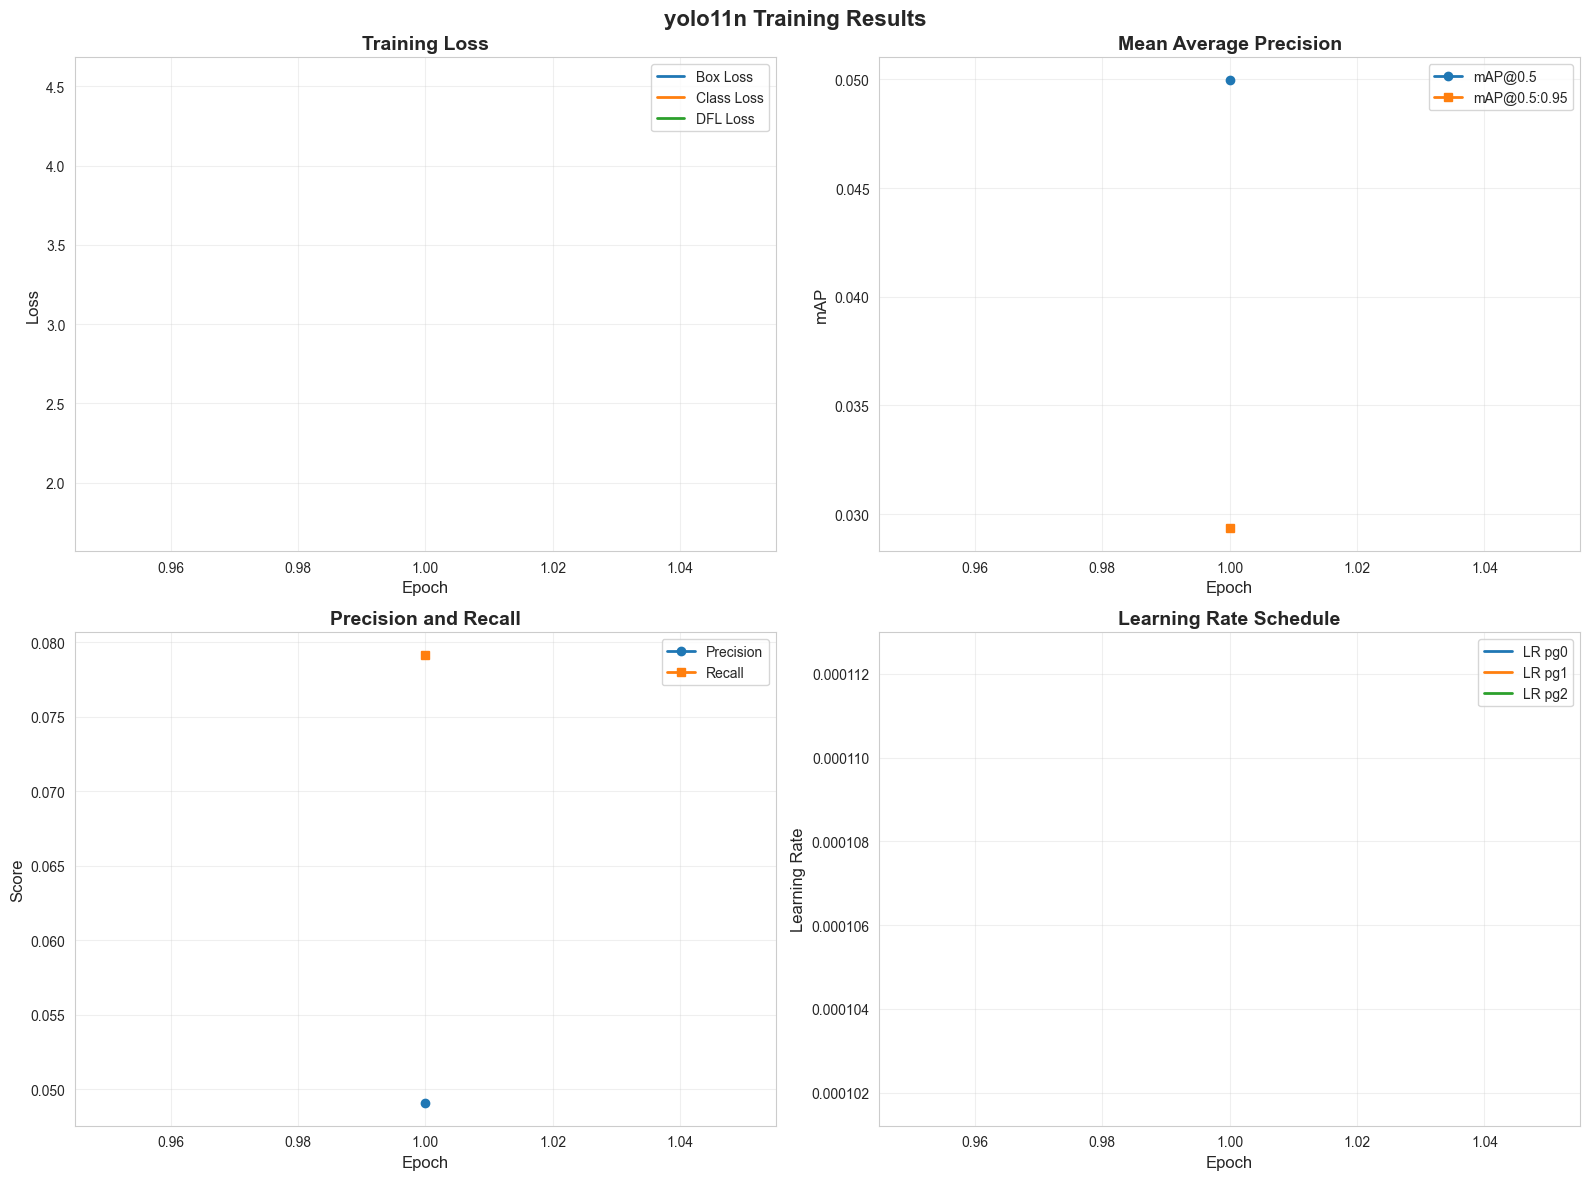

✓ Training curves saved to: /Users/mahdy/projects/computer_vision_yolo/training/runs/yolo11n_training_20251121_041144/training_curves.png


In [10]:
# Load training results
results_csv_path = RUN_DIR / 'train' / 'results.csv'

if results_csv_path.exists():
    df_results = pd.read_csv(results_csv_path)
    df_results.columns = df_results.columns.str.strip()
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{MODEL_NAME} Training Results', fontsize=16, fontweight='bold')
    
    # Plot 1: Loss curves
    ax1 = axes[0, 0]
    if 'train/box_loss' in df_results.columns:
        ax1.plot(df_results['epoch'], df_results['train/box_loss'], label='Box Loss', linewidth=2)
    if 'train/cls_loss' in df_results.columns:
        ax1.plot(df_results['epoch'], df_results['train/cls_loss'], label='Class Loss', linewidth=2)
    if 'train/dfl_loss' in df_results.columns:
        ax1.plot(df_results['epoch'], df_results['train/dfl_loss'], label='DFL Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: mAP curves
    ax2 = axes[0, 1]
    if 'metrics/mAP50(B)' in df_results.columns:
        ax2.plot(df_results['epoch'], df_results['metrics/mAP50(B)'], label='mAP@0.5', linewidth=2, marker='o')
    if 'metrics/mAP50-95(B)' in df_results.columns:
        ax2.plot(df_results['epoch'], df_results['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('mAP', fontsize=12)
    ax2.set_title('Mean Average Precision', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Precision and Recall
    ax3 = axes[1, 0]
    if 'metrics/precision(B)' in df_results.columns:
        ax3.plot(df_results['epoch'], df_results['metrics/precision(B)'], label='Precision', linewidth=2, marker='o')
    if 'metrics/recall(B)' in df_results.columns:
        ax3.plot(df_results['epoch'], df_results['metrics/recall(B)'], label='Recall', linewidth=2, marker='s')
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Score', fontsize=12)
    ax3.set_title('Precision and Recall', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Learning rate
    ax4 = axes[1, 1]
    if 'lr/pg0' in df_results.columns:
        ax4.plot(df_results['epoch'], df_results['lr/pg0'], label='LR pg0', linewidth=2)
    if 'lr/pg1' in df_results.columns:
        ax4.plot(df_results['epoch'], df_results['lr/pg1'], label='LR pg1', linewidth=2)
    if 'lr/pg2' in df_results.columns:
        ax4.plot(df_results['epoch'], df_results['lr/pg2'], label='LR pg2', linewidth=2)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('Learning Rate', fontsize=12)
    ax4.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure
    training_curves_path = RUN_DIR / 'training_curves.png'
    plt.savefig(training_curves_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f'✓ Training curves saved to: {training_curves_path}')
else:
    print(f'⚠️  Results CSV not found at {results_csv_path}')

## 10. Per-Class Performance Analysis

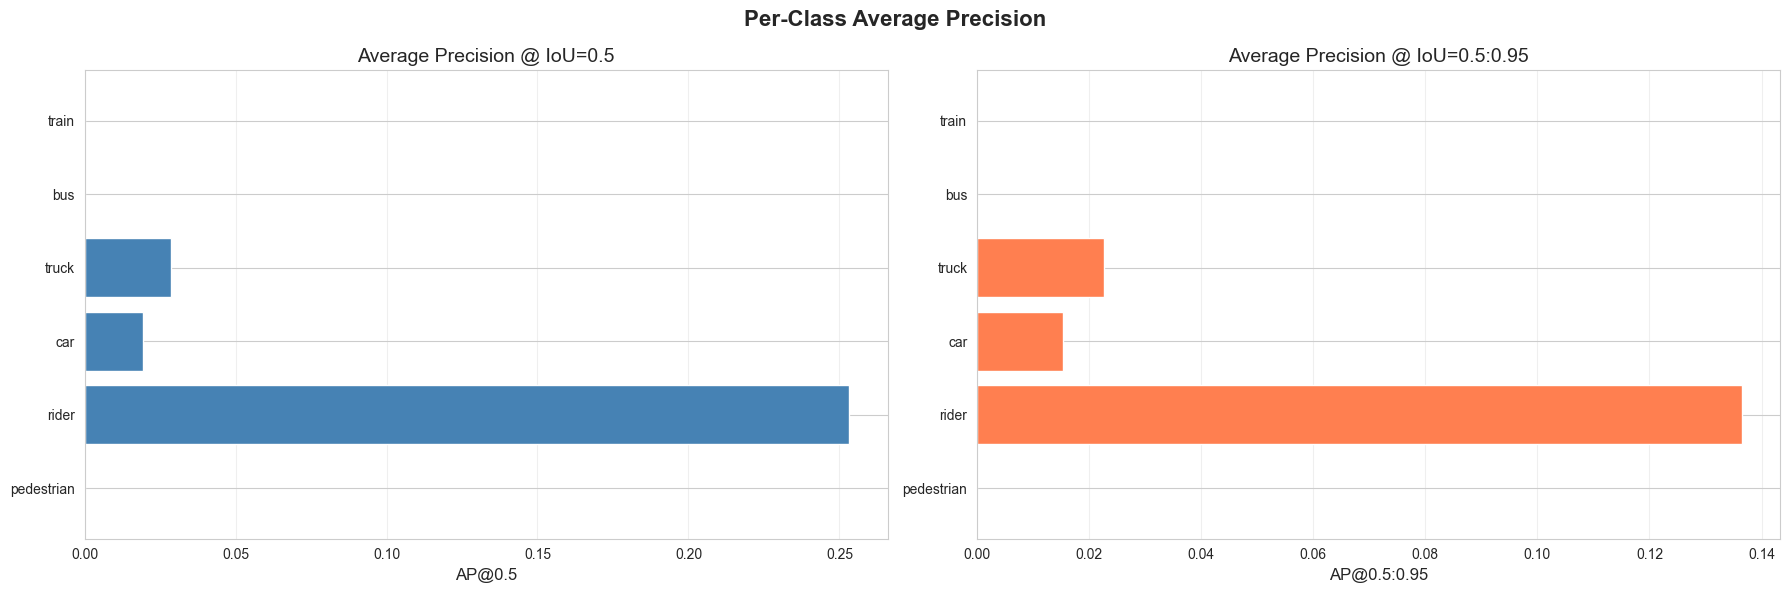

✓ Class performance chart saved to: /Users/mahdy/projects/computer_vision_yolo/training/runs/yolo11n_training_20251121_041144/class_performance.png

PER-CLASS PERFORMANCE SUMMARY
              AP@0.5  AP@0.5:0.95
rider       0.253264     0.136475
truck       0.028472     0.022578
car         0.019264     0.015411
pedestrian  0.000000     0.000000
bus         0.000000     0.000000
train       0.000000     0.000000

✓ Class metrics saved to: /Users/mahdy/projects/computer_vision_yolo/training/runs/yolo11n_training_20251121_041144/class_metrics.csv


In [11]:
# Create per-class performance visualization
if class_metrics:
    classes = list(class_metrics.keys())
    ap50_values = [class_metrics[c]['AP@0.5'] for c in classes]
    ap50_95_values = [class_metrics[c]['AP@0.5:0.95'] for c in classes]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Per-Class Average Precision', fontsize=16, fontweight='bold')
    
    # AP@0.5
    ax1.barh(classes, ap50_values, color='steelblue')
    ax1.set_xlabel('AP@0.5', fontsize=12)
    ax1.set_title('Average Precision @ IoU=0.5', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # AP@0.5:0.95
    ax2.barh(classes, ap50_95_values, color='coral')
    ax2.set_xlabel('AP@0.5:0.95', fontsize=12)
    ax2.set_title('Average Precision @ IoU=0.5:0.95', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    
    # Save figure
    class_performance_path = RUN_DIR / 'class_performance.png'
    plt.savefig(class_performance_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f'✓ Class performance chart saved to: {class_performance_path}')
    
    # Create summary table
    print('\n' + '=' * 80)
    print('PER-CLASS PERFORMANCE SUMMARY')
    print('=' * 80)
    df_class = pd.DataFrame(class_metrics).T
    df_class = df_class.sort_values('AP@0.5', ascending=False)
    print(df_class.to_string())
    print('=' * 80)
    
    # Save to CSV
    class_metrics_csv = RUN_DIR / 'class_metrics.csv'
    df_class.to_csv(class_metrics_csv)
    print(f'\n✓ Class metrics saved to: {class_metrics_csv}')

## 11. Generate PDF Report

In [12]:
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors as rl_colors
from reportlab.lib.units import inch
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER, TA_LEFT
from PIL import Image as PILImage

print('=' * 80)
print('GENERATING PDF REPORT')
print('=' * 80)

# Create PDF report
pdf_report_path = RUN_DIR / f'{MODEL_NAME}_training_report.pdf'

doc = SimpleDocTemplate(str(pdf_report_path), pagesize=A4,
                       rightMargin=30, leftMargin=30,
                       topMargin=30, bottomMargin=30)

story = []
styles = getSampleStyleSheet()

# Custom styles
title_style = ParagraphStyle(
    'CustomTitle',
    parent=styles['Heading1'],
    fontSize=24,
    textColor=rl_colors.HexColor('#2c3e50'),
    spaceAfter=30,
    alignment=TA_CENTER
)

heading_style = ParagraphStyle(
    'CustomHeading',
    parent=styles['Heading2'],
    fontSize=16,
    textColor=rl_colors.HexColor('#34495e'),
    spaceAfter=12,
    spaceBefore=20
)

# Title
story.append(Paragraph(f'{MODEL_NAME} Training Report', title_style))
story.append(Spacer(1, 12))

# Configuration info
info_data = [
    ['Model:', MODEL_NAME],
    ['Fine-tuned Model:', finetuned_model_name],
    ['Dataset:', USED_DATASET],
    ['Training Date:', datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
    ['Epochs:', str(hyperparams['epochs'])],
    ['Batch Size:', str(hyperparams['batch'])],
    ['Image Size:', str(hyperparams['imgsz'])]
]

info_table = Table(info_data, colWidths=[2.2*inch, 3.8*inch])
info_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, -1), rl_colors.HexColor('#ecf0f1')),
    ('TEXTCOLOR', (0, 0), (-1, -1), rl_colors.black),
    ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
    ('FONTNAME', (0, 0), (0, -1), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, -1), 10),
    ('BOTTOMPADDING', (0, 0), (-1, -1), 8),
    ('TOPPADDING', (0, 0), (-1, -1), 8),
    ('GRID', (0, 0), (-1, -1), 1, rl_colors.white)
]))
story.append(info_table)
story.append(Spacer(1, 20))

# Validation metrics
story.append(PageBreak())
story.append(Paragraph('Validation Metrics', heading_style))

metrics_data = [['Metric', 'Value']]
for key, value in metrics.items():
    metrics_data.append([key, f'{value:.4f}'])

metrics_table = Table(metrics_data, colWidths=[3*inch, 3*inch])
metrics_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), rl_colors.HexColor('#3498db')),
    ('TEXTCOLOR', (0, 0), (-1, 0), rl_colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 12),
    ('FONTSIZE', (0, 1), (-1, -1), 10),
    ('BOTTOMPADDING', (0, 0), (-1, -1), 8),
    ('TOPPADDING', (0, 0), (-1, -1), 8),
    ('ROWBACKGROUNDS', (0, 1), (-1, -1), [rl_colors.white, rl_colors.lightgrey]),
    ('GRID', (0, 0), (-1, -1), 1, rl_colors.black)
]))
story.append(metrics_table)
story.append(Spacer(1, 20))

# Per-class metrics
if class_metrics:
    story.append(PageBreak())
    story.append(Paragraph('Per-Class Performance', heading_style))
    
    class_data = [['Class', 'AP@0.5', 'AP@0.5:0.95']]
    for class_name, class_vals in class_metrics.items():
        class_data.append([
            class_name,
            f"{class_vals['AP@0.5']:.4f}",
            f"{class_vals['AP@0.5:0.95']:.4f}"
        ])
    
    class_table = Table(class_data, colWidths=[2*inch, 2*inch, 2*inch])
    class_table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), rl_colors.HexColor('#27ae60')),
        ('TEXTCOLOR', (0, 0), (-1, 0), rl_colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 11),
        ('FONTSIZE', (0, 1), (-1, -1), 9),
        ('BOTTOMPADDING', (0, 0), (-1, -1), 6),
        ('TOPPADDING', (0, 0), (-1, -1), 6),
        ('ROWBACKGROUNDS', (0, 1), (-1, -1), [rl_colors.white, rl_colors.lightgrey]),
        ('GRID', (0, 0), (-1, -1), 1, rl_colors.black)
    ]))
    story.append(class_table)
    story.append(Spacer(1, 20))

# Training curves
story.append(PageBreak())
story.append(Paragraph('Training Curves', heading_style))
story.append(Spacer(1, 12))

if training_curves_path.exists():
    try:
        with PILImage.open(training_curves_path) as img:
            img_width, img_height = img.size
            aspect_ratio = img_height / img_width
            pdf_width = 7 * inch
            pdf_height = pdf_width * aspect_ratio
            if pdf_height > 9 * inch:
                pdf_height = 9 * inch
                pdf_width = pdf_height / aspect_ratio
            story.append(Image(str(training_curves_path), width=pdf_width, height=pdf_height))
    except Exception as e:
        print(f'Warning: Could not load training curves: {e}')
        story.append(Paragraph('Training curves not available.', styles['Normal']))
else:
    story.append(Paragraph('Training curves not found.', styles['Normal']))

story.append(Spacer(1, 20))

# Class performance
if class_metrics:
    story.append(PageBreak())
    story.append(Paragraph('Class Performance Analysis', heading_style))
    story.append(Spacer(1, 12))
    
    if class_performance_path.exists():
        try:
            with PILImage.open(class_performance_path) as img:
                img_width, img_height = img.size
                aspect_ratio = img_height / img_width
                pdf_width = 7 * inch
                pdf_height = pdf_width * aspect_ratio
                if pdf_height > 6 * inch:
                    pdf_height = 6 * inch
                    pdf_width = pdf_height / aspect_ratio
                story.append(Image(str(class_performance_path), width=pdf_width, height=pdf_height))
        except Exception as e:
            print(f'Warning: Could not load class performance: {e}')
            story.append(Paragraph('Class performance chart not available.', styles['Normal']))
    else:
        story.append(Paragraph('Class performance chart not found.', styles['Normal']))
    
    story.append(Spacer(1, 20))

# Footer
story.append(Spacer(1, 30))
story.append(Paragraph('Generated by YOLO Training Notebook',
                      ParagraphStyle('Footer', parent=styles['Normal'],
                                   alignment=TA_CENTER, textColor=rl_colors.grey)))
story.append(Paragraph('BDD100K Dataset - Computer Vision Project',
                      ParagraphStyle('Footer2', parent=styles['Normal'],
                                   alignment=TA_CENTER, textColor=rl_colors.grey)))

# Build PDF
doc.build(story)

print(f'✓ PDF report generated: {pdf_report_path}')
print(f'  Size: {pdf_report_path.stat().st_size / 1024:.2f} KB')
print('=' * 80)

GENERATING PDF REPORT
✓ PDF report generated: /Users/mahdy/projects/computer_vision_yolo/training/runs/yolo11n_training_20251121_041144/yolo11n_training_report.pdf
  Size: 623.70 KB
✓ PDF report generated: /Users/mahdy/projects/computer_vision_yolo/training/runs/yolo11n_training_20251121_041144/yolo11n_training_report.pdf
  Size: 623.70 KB


## 12. Summary

In [13]:
print('=' * 80)
print('TRAINING COMPLETED SUCCESSFULLY')
print('=' * 80)
print(f'\nModel: {MODEL_NAME}')
print(f'Dataset: {USED_DATASET}')
print(f'\nFine-tuned Model:')
print(f'  Path: {finetuned_model_path}')
print(f'  Name: {finetuned_model_name}')
print(f'\nValidation Metrics:')
print(f'  mAP@0.5: {metrics["mAP@0.5"]:.4f}')
print(f'  mAP@0.5:0.95: {metrics["mAP@0.5:0.95"]:.4f}')
print(f'  Precision: {metrics["precision"]:.4f}')
print(f'  Recall: {metrics["recall"]:.4f}')
print(f'\nOutput Directory: {RUN_DIR}')
print(f'\nGenerated Files:')
print(f'  🎯 Fine-tuned model: {finetuned_model_path}')
print(f'  📊 Metadata: {metadata_path}')
print(f'  📈 Training curves: training_curves.png')
if class_metrics:
    print(f'  📊 Class performance: class_performance.png')
    print(f'  📄 Class metrics CSV: class_metrics.csv')
print(f'  📄 PDF Report: {MODEL_NAME}_training_report.pdf')
print(f'\n💾 All results saved to: {RUN_DIR}')
print(f'🎯 Fine-tuned model ready for testing!')
print('\n🚀 Next Steps:')
print(f'  1. Review the PDF report: {pdf_report_path}')
print(f'  2. Use fine-tuned model for testing: {finetuned_model_name}')
print(f'  3. Run testing notebook on test split')
print('=' * 80)

TRAINING COMPLETED SUCCESSFULLY

Model: yolo11n
Dataset: bdd100k_tmp_images_limited

Fine-tuned Model:
  Path: /Users/mahdy/projects/computer_vision_yolo/models/yolo11n/yolo11n_finetuned-20251121.pt
  Name: yolo11n_finetuned-20251121.pt

Validation Metrics:
  mAP@0.5: 0.0502
  mAP@0.5:0.95: 0.0291
  Precision: 0.0503
  Recall: 0.0748

Output Directory: /Users/mahdy/projects/computer_vision_yolo/training/runs/yolo11n_training_20251121_041144

Generated Files:
  🎯 Fine-tuned model: /Users/mahdy/projects/computer_vision_yolo/models/yolo11n/yolo11n_finetuned-20251121.pt
  📊 Metadata: /Users/mahdy/projects/computer_vision_yolo/models/yolo11n/yolo11n_finetuned-20251121_metadata.json
  📈 Training curves: training_curves.png
  📊 Class performance: class_performance.png
  📄 Class metrics CSV: class_metrics.csv
  📄 PDF Report: yolo11n_training_report.pdf

💾 All results saved to: /Users/mahdy/projects/computer_vision_yolo/training/runs/yolo11n_training_20251121_041144
🎯 Fine-tuned model ready for